In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm
import pmdarima as pm
import pickle
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('./data/processed_data.csv', index_col=0)
data.index = pd.to_datetime(data.index)

In [3]:
feature = 'total load actual'
y = data.rolling(24*7, center=True).mean()[feature].dropna()

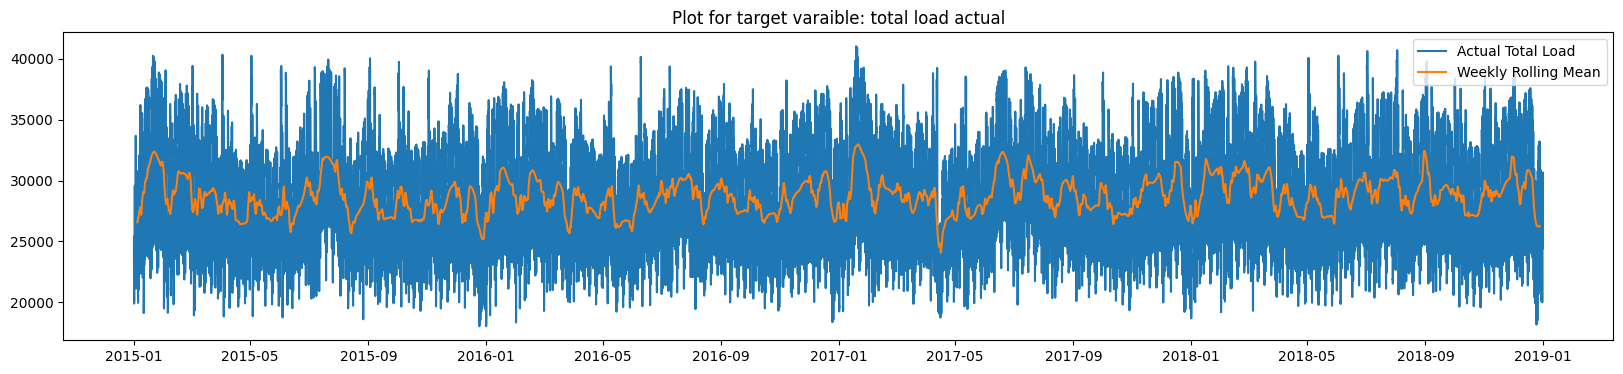

In [4]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(data[feature])
ax.plot(y)
ax.set_title("Plot for target varaible: "+feature)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.legend(['Actual Total Load', 'Weekly Rolling Mean'])
plt.show()

## Stationary Tests

### For the raw data

In [5]:
y = data['total load actual']

In [6]:
result_diff = adfuller(y)
print(f"ADF Statistic of the raw data: {result_diff[0]:.4f}, p-value: {result_diff[1]:.4f}")

ADF Statistic of the raw data: -21.4339, p-value: 0.0000


Since p-value <= 0.05, ADF reject H0 and the data is likely stationary

In [7]:
stat, p_value, lags, crit = kpss(y, regression='c')

print("KPSS Statistic :", stat)
print("p-value        :", p_value)
print("lags used      :", lags)
print("critical value :", crit)

KPSS Statistic : 0.8708093229455381
p-value        : 0.01
lags used      : 70
critical value : {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/var/folders/8f/xm08m3255q9b0j33fhp73q_w0000gn/T/ipykernel_11733/1010370939.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p_value, lags, crit = kpss(y, regression='c')


Since p-value <=> 0.05, KPSS reject H0 and the data is not likely stationary

The results from ADF and KPSS do not match and we would like to perfrom differencing on the raw data

### For the 1st differencing data:

In [8]:
diff = data['total load actual'].diff().dropna()

### Augmented Dickey-Fuller (ADF) test

In [9]:
result_diff = adfuller(diff)
print(f"ADF Statistic after 1st diff: {result_diff[0]:.4f}, p-value: {result_diff[1]:.4f}")

ADF Statistic after 1st diff: -34.2917, p-value: 0.0000


Since p-value <= 0.05, ADF reject H0 and the data is likely stationary

### KPSS Test

In [10]:
diff = data['total load actual'].diff().dropna()
stat, p_value, lags, crit = kpss(diff, regression='c')

print("KPSS Statistic :", stat)
print("p-value        :", p_value)
print("lags used      :", lags)
print("critical value :", crit)

KPSS Statistic : 0.02562935109780075
p-value        : 0.1
lags used      : 1431
critical value : {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/var/folders/8f/xm08m3255q9b0j33fhp73q_w0000gn/T/ipykernel_11733/943923991.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p_value, lags, crit = kpss(diff, regression='c')


Since p-value > 0.05, KPSS fail to reject H0 and the data is likely stationary

Both tests show the data is stationary after 1st differencing and the energy consumption data is suitable for ARIMA.

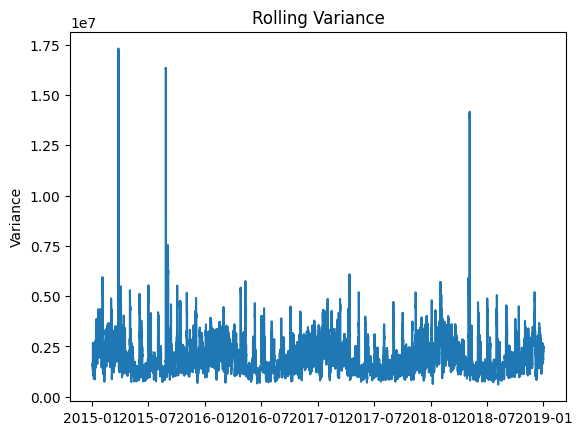

In [11]:
rolling_var = diff.rolling(24).var()   # choose window ~ seasonal period
plt.plot(rolling_var)
plt.title("Rolling Variance")
plt.ylabel("Variance")
plt.show()

It shows that there is a few outliers in the rolling variance but it is mainly consistent

### ACF and PACF Plot

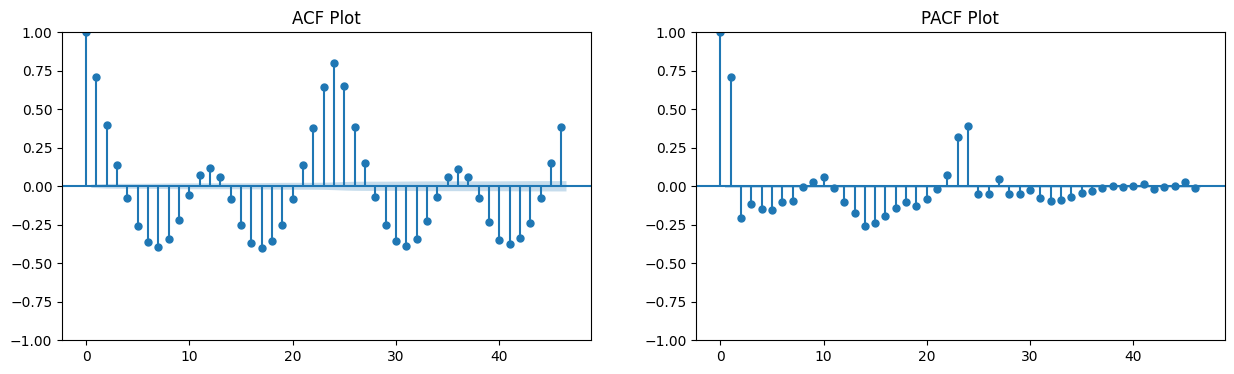

In [12]:
fig, axes = plt.subplots(1,2, figsize=(15,4))
plot_acf(diff, ax=axes[0])
axes[0].set_title("ACF Plot")
plot_pacf(diff, ax=axes[1])
axes[1].set_title("PACF Plot")
plt.show()

## Seasonal Decomposition Test

For all data

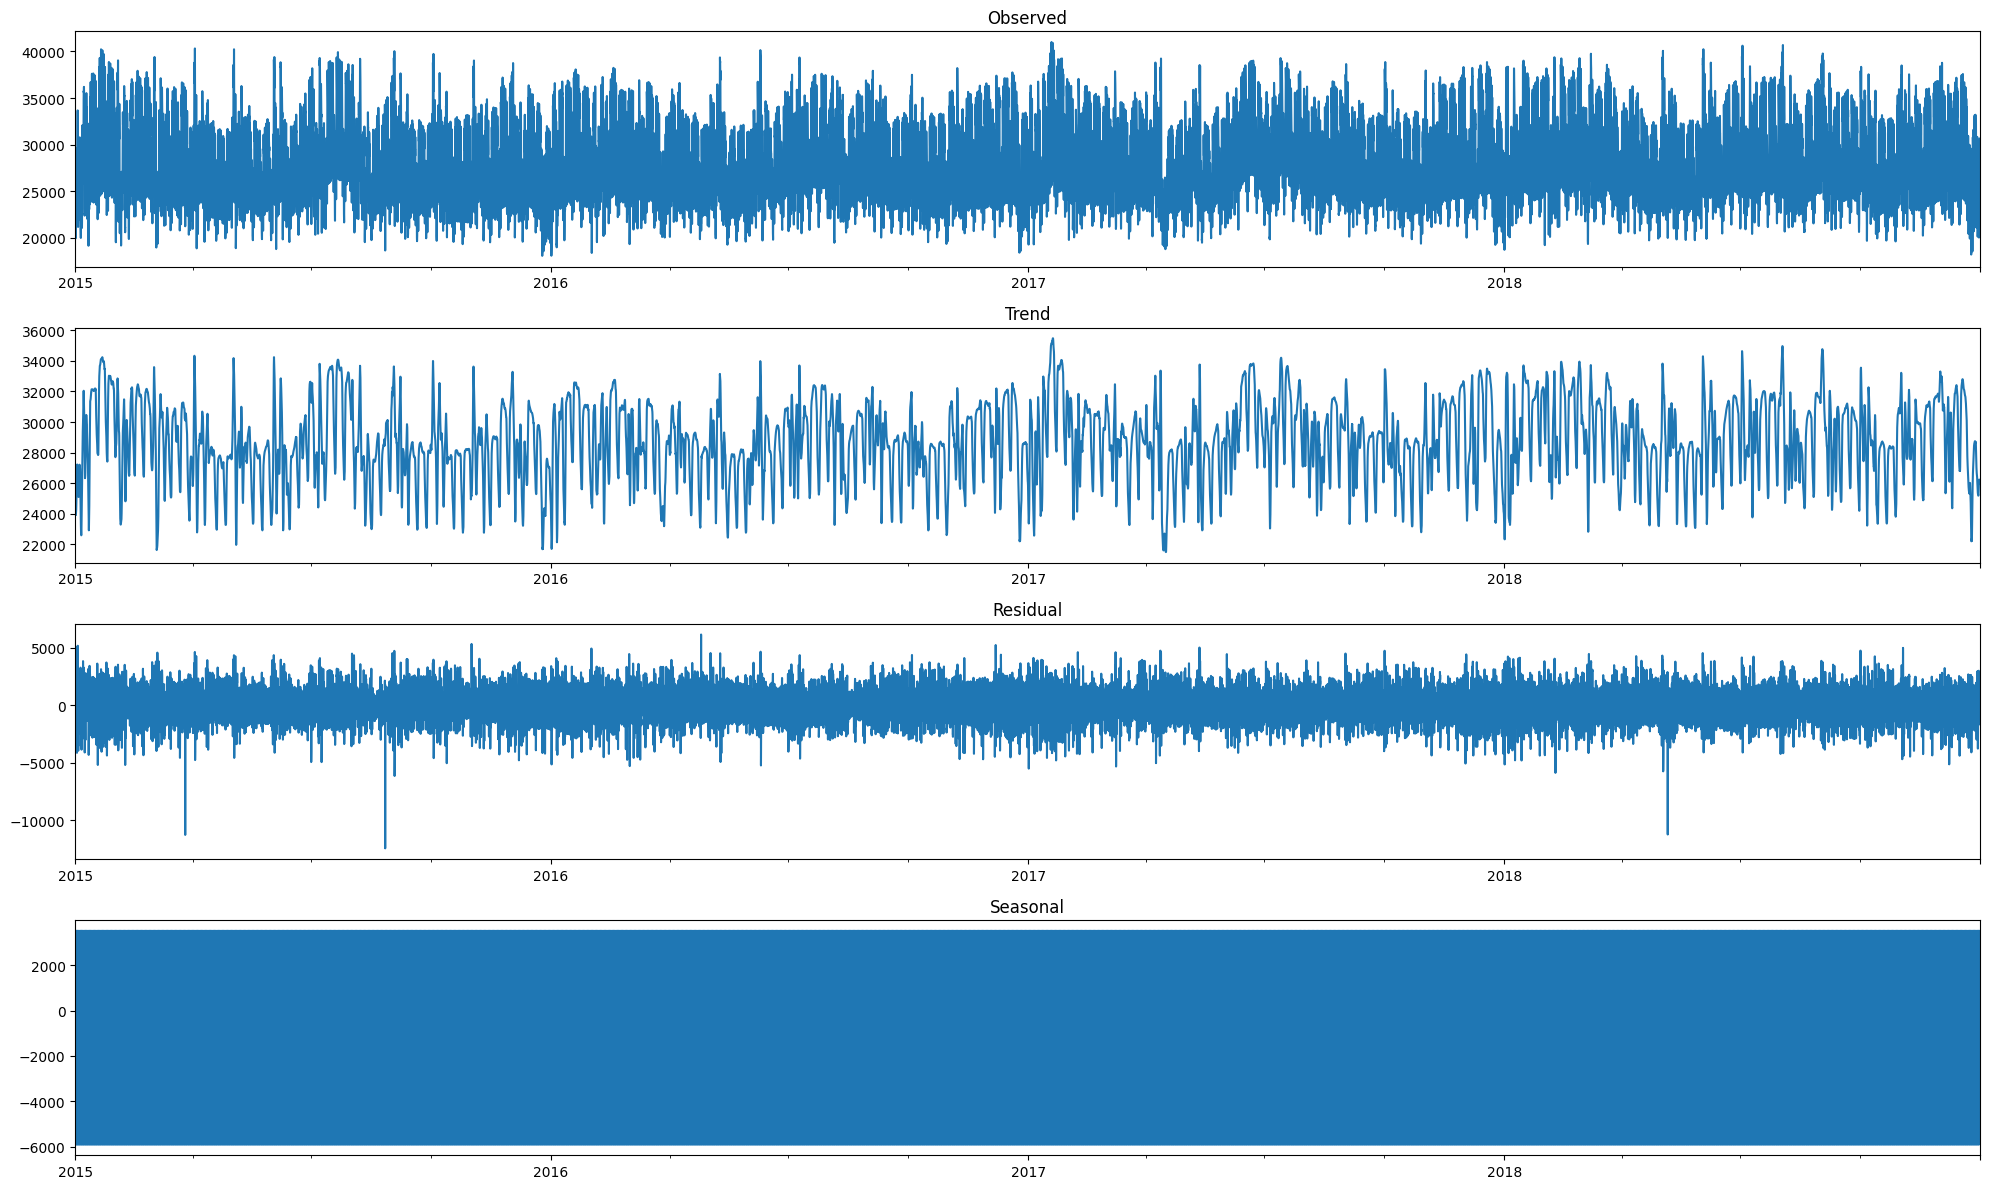

In [13]:
decompose_result = sm.tsa.seasonal_decompose(data[feature], model='additive', period=24)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
decompose_result.observed.plot(ax=ax1, title='Observed')
decompose_result.trend.plot(ax=ax2, title='Trend')
decompose_result.resid.plot(ax=ax3, title='Residual')
decompose_result.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

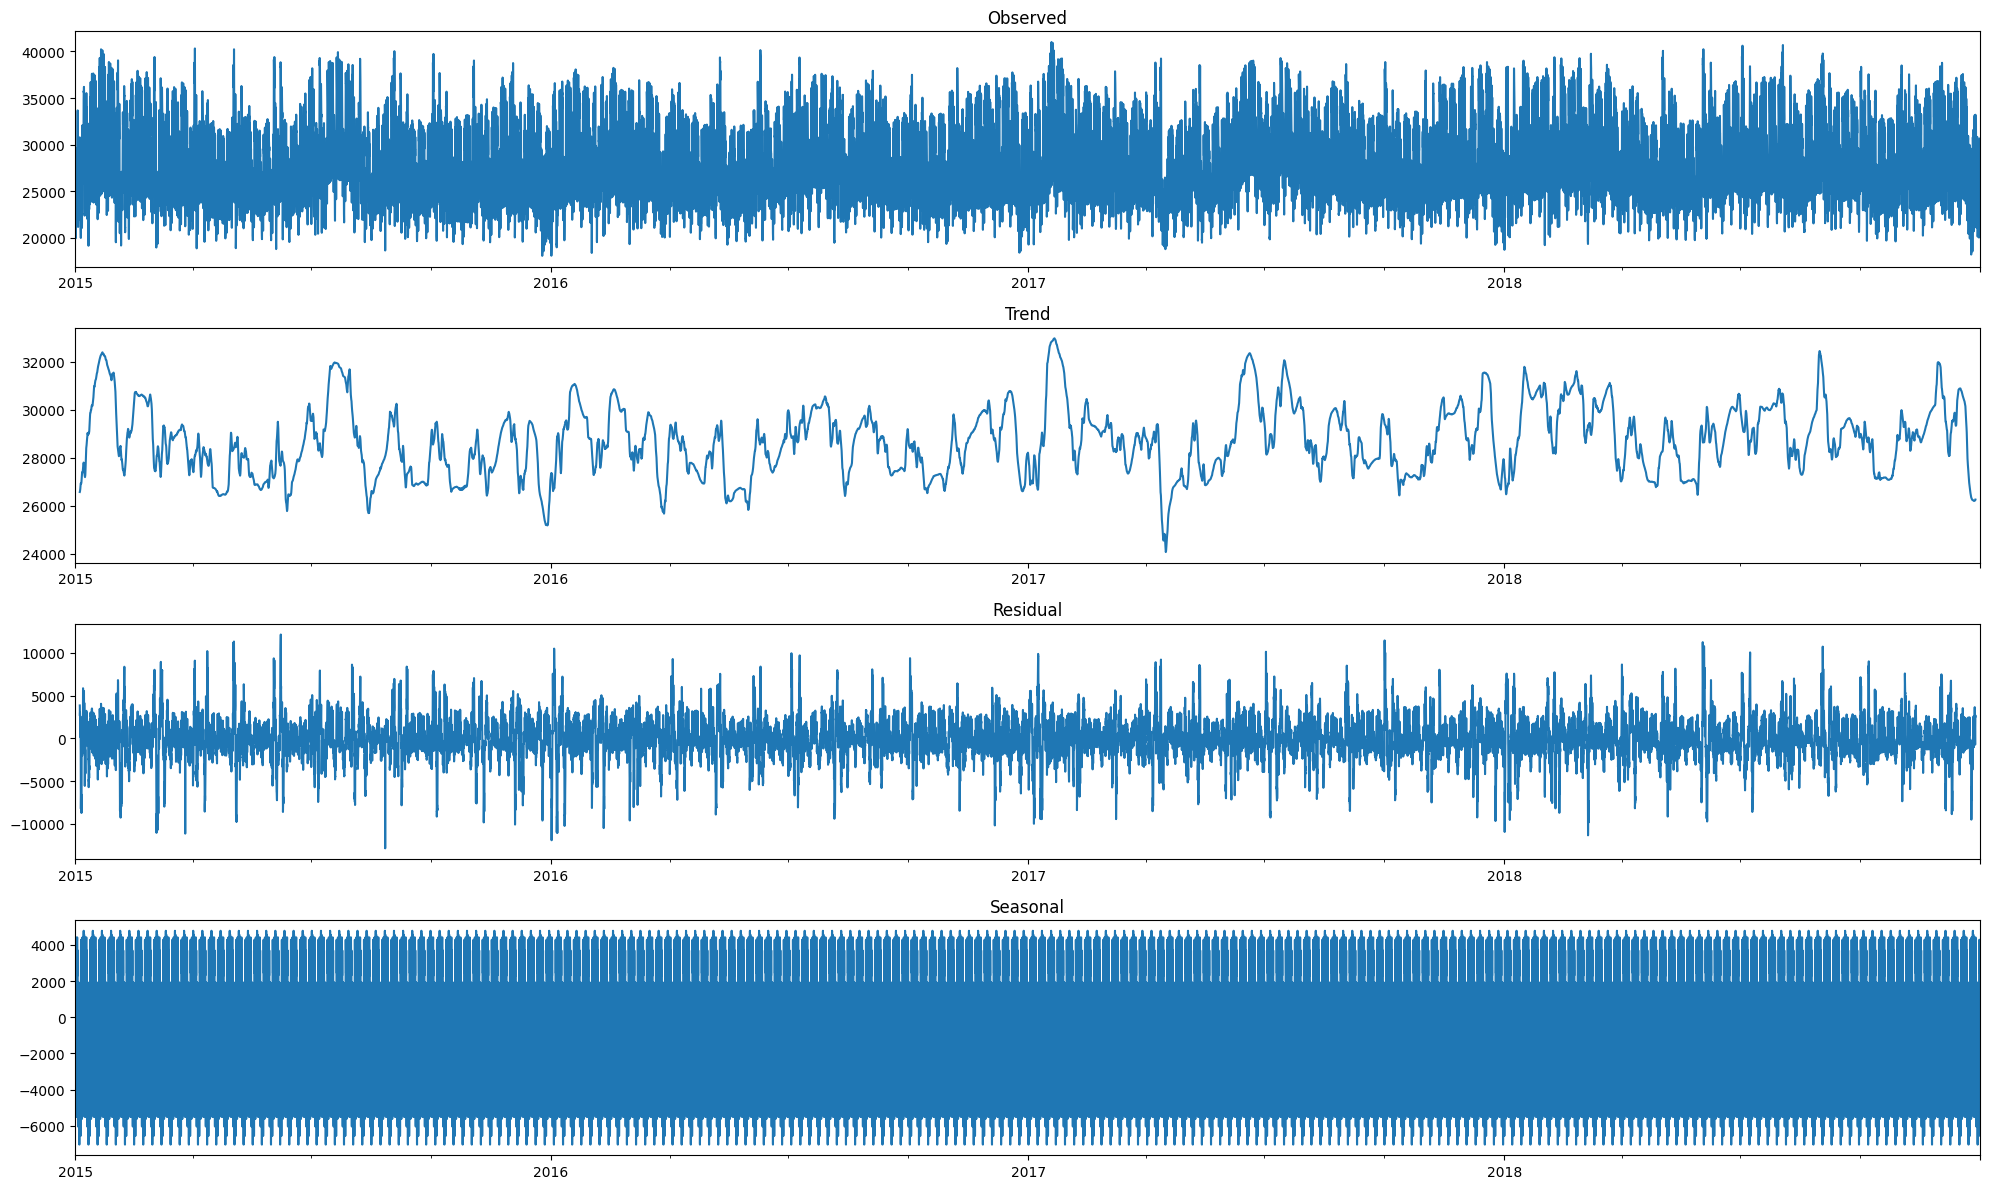

In [14]:
decompose_result = sm.tsa.seasonal_decompose(data[feature], model='additive', period=24*7)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
decompose_result.observed.plot(ax=ax1, title='Observed')
decompose_result.trend.plot(ax=ax2, title='Trend')
decompose_result.resid.plot(ax=ax3, title='Residual')
decompose_result.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

## ARIMA

In [15]:
y = data[feature]
y = y.asfreq('H')
train_size = int(len(y)*0.8)
train, test = y[:train_size], y[train_size:]

/var/folders/8f/xm08m3255q9b0j33fhp73q_w0000gn/T/ipykernel_11733/222657285.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  y = y.asfreq('H')


In [16]:
train = train.asfreq("h")

model = ARIMA(
    train,
    order=(3,1,0),
    seasonal_order=(1,0,1,24),
    enforce_stationarity=False,
    enforce_invertibility=False,
    trend='t'
)

model_fit = model.fit(
    method="statespace",
    method_kwargs={"method": "powell", "maxiter": 30}
)

print(model_fit.summary())


                                     SARIMAX Results                                      
Dep. Variable:                  total load actual   No. Observations:                28051
Model:             ARIMA(3, 1, 0)x(1, 0, [1], 24)   Log Likelihood             -223701.269
Date:                            Thu, 04 Dec 2025   AIC                         447416.538
Time:                                    19:21:56   BIC                         447474.224
Sample:                                01-01-2015   HQIC                        447435.108
                                     - 03-14-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             3.3098    200.905      0.016      0.987    -390.458     397.077
ar.L1          0.4001      0.002   

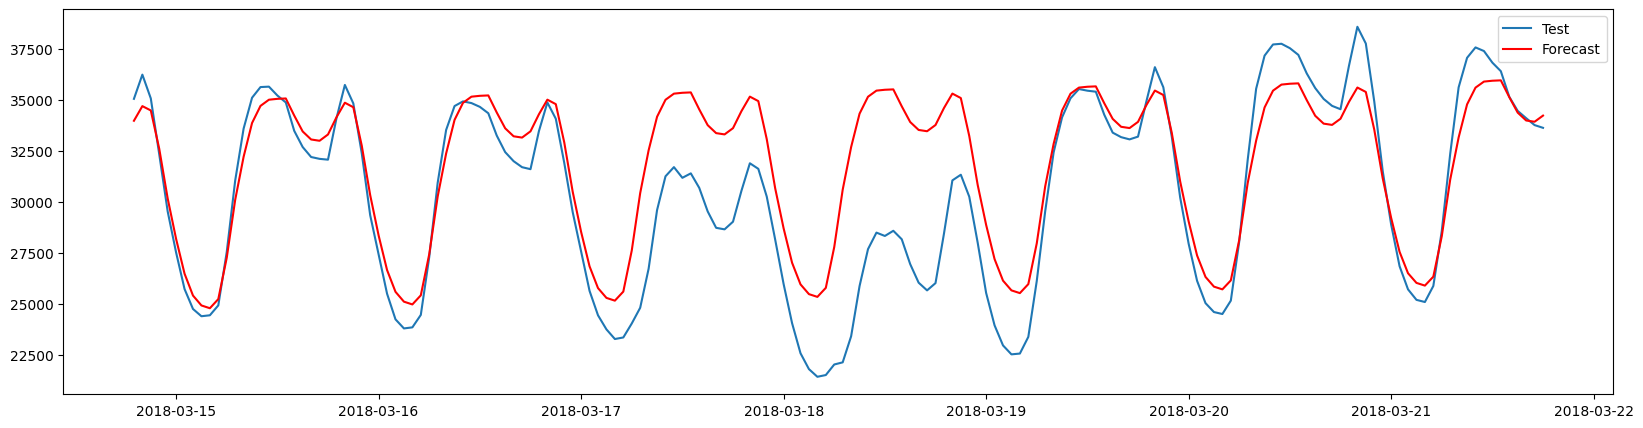

Mean Squared Error: 644728015.1193


In [17]:
# forecast = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
forecast = model_fit.forecast(steps=len(test))
n_steps = 24*7
# Plot
plt.figure(figsize=(20,5))
# plt.plot(train, label='Train')
plt.plot(test[:n_steps], label='Test')
plt.plot(test.index[:n_steps], forecast[:n_steps], label='Forecast', color='red')
plt.legend()
plt.show()

# Evaluate
mse = mean_squared_error(test, forecast)
print(f"Mean Squared Error: {mse:.4f}")

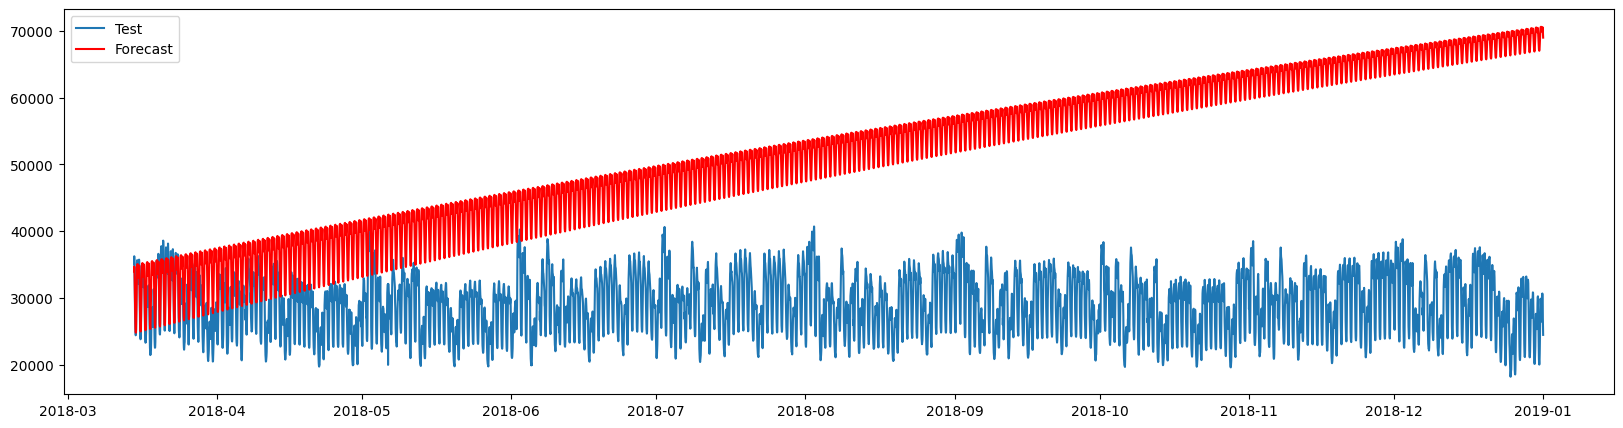

Mean Squared Error: 644728015.1193


In [18]:
# forecast = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
forecast = model_fit.forecast(steps=len(test))
n_steps = 24*7
# Plot
plt.figure(figsize=(20,5))
# plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.show()

# Evaluate
mse = mean_squared_error(test, forecast)
print(f"Mean Squared Error: {mse:.4f}")


---

## Get exogenous features

In [19]:
data['hour'] = data.index.hour

In [20]:
data['peak_hour'] = 0

data.loc[((data['hour'] >= 8) & (data['hour'] <= 14)) |((data['hour'] >= 18) & (data['hour'] <= 21)),'peak_hour'] = 2

data.loc[(data['hour'] >= 15) & (data['hour'] <= 17),'peak_hour'] = 1

In [21]:
data['hour_sin'] = np.sin(2*np.pi*data.index.hour / 24)
data['hour_cos'] = np.cos(2*np.pi*data.index.hour / 24)
data['week_sin'] = np.sin(2*np.pi*data.index.dayofweek/7)
data['week_cos'] = np.cos(2*np.pi*data.index.dayofweek/7)

data['is_weekend'] = (data.index.dayofweek >= 5).astype(int)

In [22]:
data['total load 1-day lag']  = data['total load actual'].shift(24)
data['total load 1-week lag'] = data['total load actual'].shift(168)


data['total load 1-week lag'] = data['total load 1-day lag'].fillna(data['total load 1-day lag'])
data['total load 1-week lag'] = data['total load 1-week lag'].fillna(data['total load 1-week lag'].mean())

data['total load 1-day lag'] = data['total load 1-day lag'].fillna(data['total load 1-day lag'].mean())

In [23]:
data['avg_temp'] = np.mean(data[['temp_Barcelona', 'temp_Bilbao', 'temp_Madrid', 'temp_Seville', 'temp_Valencia']], axis=1)

In [24]:
X_col = [col for col in data.columns if ('forecast' not in col) and ('generation' not in col) and (col != 'total load actual')]

In [25]:
corr = data[X_col].corrwith(data['total load actual'])

corr_sorted = corr.abs().sort_values(ascending=False)

feature_selected = corr_sorted[:18].index.tolist()
feature_selected.remove('hour')
feature_selected.remove('humidity_Barcelona')
feature_selected.remove('humidity_Valencia')
feature_selected.remove('humidity_Bilbao')
feature_selected.remove('week_sin')
feature_selected.remove('temp_min_Seville')
feature_selected.remove('temp_Valencia')



In [26]:
feature_selected

['total load 1-week lag',
 'total load 1-day lag',
 'peak_hour',
 'hour_cos',
 'hour_sin',
 'humidity_Seville',
 'is_weekend',
 'temp_min_Valencia',
 'avg_temp',
 'temp_max_Madrid',
 'temp_Seville']

In [27]:
X = data[feature_selected]

In [28]:
y = data[feature]
y = y.asfreq('h')
train_size = int(len(y)*0.8)
train, test = y[:train_size], y[train_size:]
Xtrain, Xtest = X[:train_size], X[train_size:]

In [29]:
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest  = scaler.transform(Xtest)

## Model Training

In [30]:
model = SARIMAX(
    train,
    exog=Xtrain,
    order=(1,1,1),
    seasonal_order=(1,0,0,24),
    enforce_stationarity=False,
    enforce_invertibility=False,
    trend='n',
    freq='h'
)

model_fit = model.fit(method="lbfgs", maxiter=50)

model_fit.summary()


/usr/local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                   total load actual   No. Observations:                28051
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 24)   Log Likelihood             -225872.278
Date:                             Thu, 04 Dec 2025   AIC                         451774.557
Time:                                     19:28:03   BIC                         451898.169
Sample:                                 01-01-2015   HQIC                        451814.348
                                      - 03-14-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1572.9096      7.895    199.232      0.000    1557.436    1588.383
x2          1572.9096      7.895    199.232      0.000    1557.436    1588.383
x3            59.4419      5.914     10.050      0.000      47.850      71.034
x4          -742.6938     26.902    -27.608      0.000    -795.420    -689.968
x5          -835.6170     28.508    -29.311      0.000    -891.492    -779.742
x6            64.0610     13.335      4.804      0.000      37.924      90.198
x7            38.5672     10.982      3.512      0.000      17.044      60.091
x8           121.2493     27.231      4.453      0.000      67.878     174.621
x9         -1369.2025     88.650    -15.445      0.000   -1542.954   -1195.451
x10          231.3909     30.557      7.572      0.000     171.500     291.281
x11          347.0832     41.204      8.424      0.000     266.325     427.841
ar.L1          0.2903      0.010     28.777      0.000       0.271       0.310
ma.L1          0.1072      0.010     10.990      0.000       0.088       0.126
ar.S.L24      -0.1947      0.003    -56.832      0.000      -0.201      -0.188
sigma2       5.92e+05   1513.196    391.205      0.000    5.89e+05    5.95e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):           2188693.91
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                             0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        46.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.19e+18. Standard errors may be unstable.
"""

## Model Analysis

In [31]:
train_pred = model_fit.fittedvalues
test_forecast = model_fit.get_forecast(steps=len(test), exog=Xtest)
test_pred = test_forecast.predicted_mean

In [32]:
print("Testing Mean Absolute Percentage Error: {}".format(mean_absolute_percentage_error(train, train_pred)*100))
print("Testing Mean Absolute Percentage Error: {}".format(mean_absolute_percentage_error(test, test_pred)*100))

Testing Mean Absolute Percentage Error: 1.6530983783692257
Testing Mean Absolute Percentage Error: 8.321893634713911


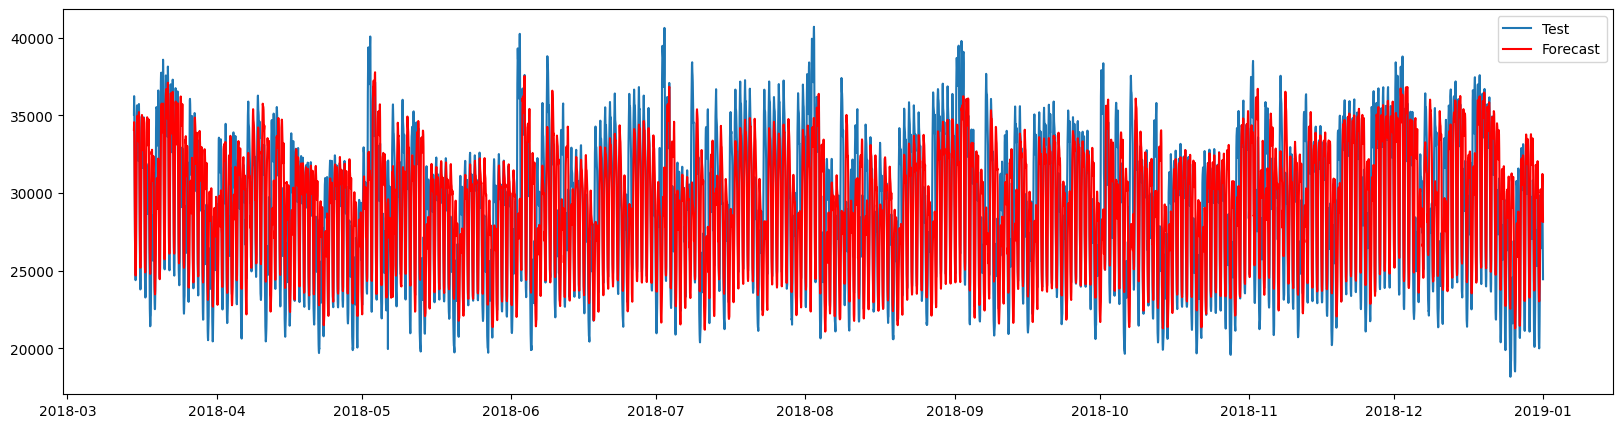

In [33]:

n_steps = 24*7
# Plot
plt.figure(figsize=(20,5))
# plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, test_pred, label='Forecast', color='red')
plt.legend()
plt.show()


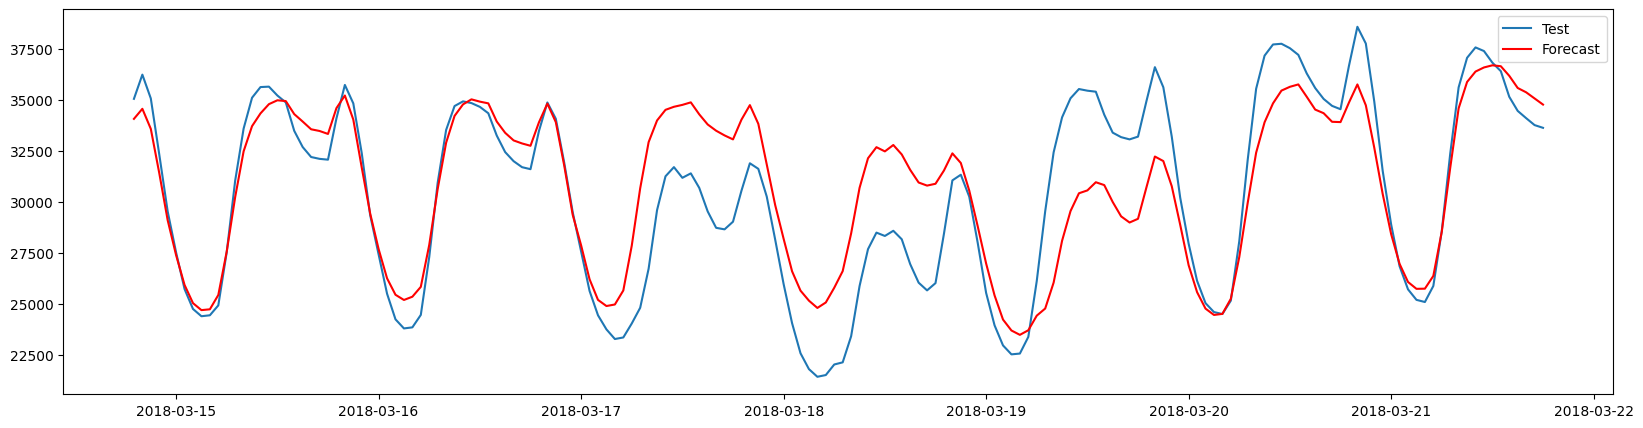

In [34]:
n_steps = 24*7
# Plot
plt.figure(figsize=(20,5))
# plt.plot(train, label='Train')
plt.plot(test[:n_steps], label='Test')
plt.plot(test.index[:n_steps], test_pred[:n_steps], label='Forecast', color='red')
plt.legend()

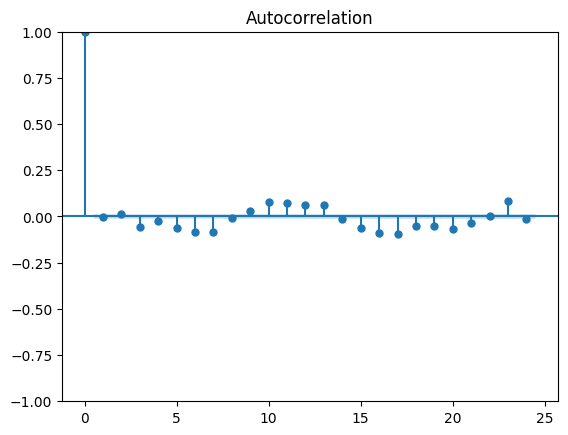

In [35]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(model_fit.resid, lags=24)
plt.show()



In [42]:
np.save("sarimax_params.npy", model_fit.params)

---

## Load and test the saved model

In [45]:
params = np.load("sarimax_params.npy")

model = SARIMAX(train, exog=Xtrain, order=(1,1,1), seasonal_order=(1,0,0,24))
loaded_model = model.filter(params)

In [46]:
train_pred = loaded_model.fittedvalues
test_forecast = loaded_model.get_forecast(steps=len(test), exog=Xtest)
test_pred = test_forecast.predicted_mean

In [47]:
print("Testing Mean Absolute Percentage Error: {}".format(mean_absolute_percentage_error(train, train_pred)*100))
print("Testing Mean Absolute Percentage Error: {}".format(mean_absolute_percentage_error(test, test_pred)*100))

Testing Mean Absolute Percentage Error: 1.652866079056268
Testing Mean Absolute Percentage Error: 8.321893634713913
